# TensorFlow 'Wide and Deep' neural nets

One modification to a standard sequential model is to use a 'Wide and Deep' model as described by Cheng et al. (https://arxiv.org/abs/1606.07792).

In this model structure the input layer is brought back in to the model just prior to the output layer. This may be of use if both 'shallow' and 'deep' learning may be of use. Here we will demonstrate how this is performed in Keras, which will also demonstrate how Keras can be used to easily build more complex model structures.

We will focus just on the essential code here (not, for example, using k-fold validation) for simplicity. *Please see our previous TensorFlow examples first*.

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

## Load modules

In [2]:
import numpy as np
import pandas as pd

# sklearn for pre-processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold

# TensorFlow api model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

2021-10-09 23:10:07.870756: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Download data if not previously downloaded

In [3]:
download_required = True

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

## Define function to scale data

In neural networks it is common to to scale input data 0-1 rather than use standardisation (subtracting mean and dividing by standard deviation) of each feature).

In [4]:
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc
    

## Load data

In [5]:
data = pd.read_csv('data/processed_data.csv')
# Make all data 'float' type
data = data.astype(float)
data.drop('PassengerId', inplace=True, axis=1)
X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'
# Convert to NumPy as required for k-fold splits
X_np = X.values
y_np = y.values

# Set up neural net

Here we use the api-based method to set up a TensorFlow neural network. This method allows us
to more flexibly define the inputs for each layer, rather than assuming there is a simple sequence as with the Sequential method.

We will put construction of the neural net into a separate function.

The neural net is a relatively simple network. The inputs are connected to two hidden layers (of 240 and 50 nodes) before being connected to two output nodes corresponding to each class (died and survived). It also contains some useful additions (batch normalisation and dropout) as described below.

The only difference to our previous example is that we add in an extra concatenation layer that combines the last deep layer with the orginal input layer.


The layers of the network are:

1) An input layer (which does need to be defined)

2) A fully-connected (dense) layer.This is defined by the number of inputs (the number of input features) and the number of outputs. We will expand out feature data set up to 240 outputs. The output of the layer uses ReLU (rectified linear unit) activation. ReLU activation is most common for the inner layers of a neural network. Negative input values are set to zero. Positive input values are left unchanged.

3) A batch normalisation layer. This is not usually used for small models, but can increase the speed of training for larger models. It is added here as an example of how to include it (in large models all dense layers would be followed by a batch normalisation layer). The layer definition includes the number of inputs to normalise. 

4) A dropout layer. This layer randomly sets outputs from the preceding layer to zero during training (a different set of outputs is zeroed for each training iteration). This helps prevent over-fitting of the model to the training data. Typically between 0.1 and 0.3 outputs are set to zero (p=0.1 means 10% of outputs are set to zero).

5) A second fully connected layer which reduces the network down to 50 nodes. This again uses ReLU activation and is followed by batch normalisation, and dropout layers.

6) A concetnation layer which combines the last deep layer with the original input layer.

7) A final fully connected linear layer of one nodes (more nodes could be used for more classes, in which case use softmax activation and categorical_crossentropy in the loss function). The output of the net is the probability of surviving (usually a probability of >= 0.5 will be classes as ‘survived’).

In [6]:
def make_net(number_features, learning_rate=0.003):
    
    # Clear Tensorflow
    K.clear_session()
    
    # Define layers
    inputs = layers.Input(shape=number_features)
    dense_1 = layers.Dense(240, activation='relu')(inputs)
    norm_1 = layers.BatchNormalization()(dense_1)
    dropout_1 = layers.Dropout(0.25)(norm_1)
    dense_2 = layers.Dense(50, activation='relu')(dropout_1)
    
    # Create a layer that concatenates last dense layer and the input layer
    concat = layers.Concatenate()([inputs, dense_2])
    
    # Base output on concatenated layer
    outputs = layers.Dense(1, activation='sigmoid')(concat)
    net = Model(inputs, outputs)
    
    # Compiling model
    opt = Adam(lr=learning_rate)
    net.compile(loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy'])
    return net


## Show summary of the model structure

Here we will create a model with 10 input features and show the structure of the model as  atable and as a graph.

In [7]:
model = make_net(10)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 240)          2640        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 240)          960         dense[0][0]                      
__________________________________________________________________________________________________
dropout (Dropout)               (None, 240)          0           batch_normalization[0][0]        
______________________________________________________________________________________________

2021-10-09 23:10:09.185338: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-09 23:10:09.186067: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-09 23:10:10.817928: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-09 23:10:10.818210: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 Ti computeCapability: 7.5
coreClock: 1.485GHz coreCount: 16 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 178.84GiB/s
2021-10-09 23:10:10.818239: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-10-09 23:10:10.819371: I tensorflow/stream_executor/platform

Note that the plot of the model shows how the imput layer is connected to both the first dense layer and the concatenation layer prior to the output.

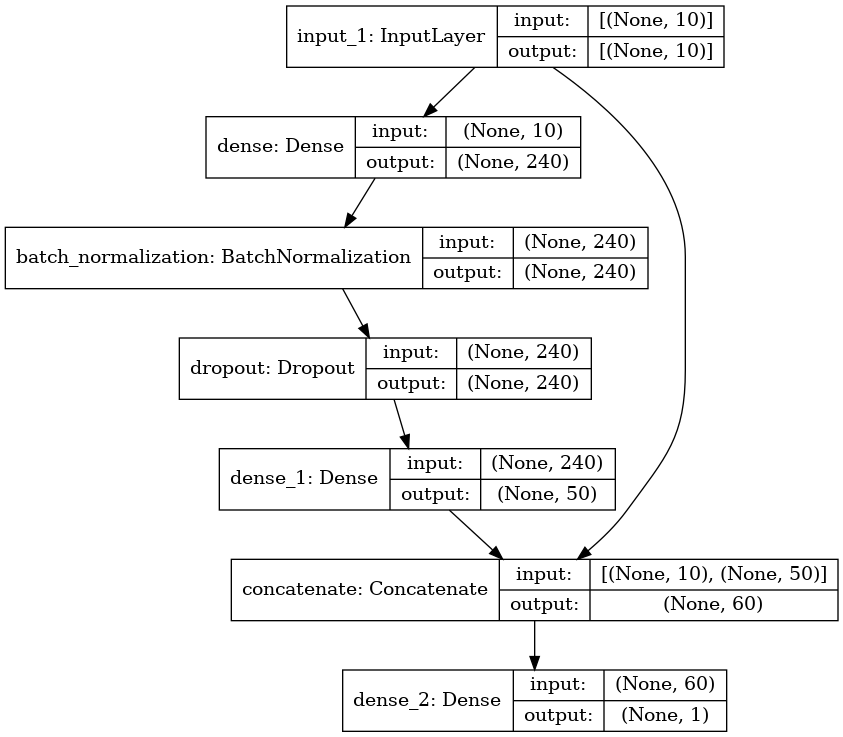

In [8]:
# If necessary pip or conda install pydot and graphviz
keras.utils.plot_model(model, "titanic_tf_model.png", show_shapes=True)

## Training the model

In [9]:
from sklearn.model_selection import train_test_split

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_np, y_np, test_size = 0.25)

# Scale data
X_train_sc, X_test_sc = scale_data(X_train, X_test)

# Define network
number_features = X_train_sc.shape[1]
model = make_net(number_features)

# Train model
history = model.fit(X_train_sc,
                    y_train,
                    epochs=250,
                    batch_size=512,
                    validation_data=(X_test_sc, y_test),
                    verbose=0)

2021-10-09 23:10:11.598142: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-09 23:10:11.615090: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz
2021-10-09 23:10:12.076774: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


`history` is a dictionary containing data collected during training. Let's take a look at the keys in this dictionary (these are the metrics monitored during training):

In [10]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Plot training history:

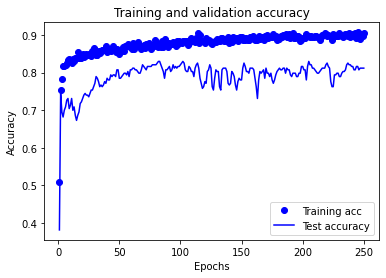

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()